In [144]:
import os
from os import listdir
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [145]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [146]:
import os
import pandas as pd

EOSINOPHIL_dirs = [
    r'dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL'
]

LYMPHOCYTE_dir = [ r'dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE']

MONOCYTE_dirs = [
    r'dataset2-master/dataset2-master/images/TRAIN/MONOCYTE'
]

NEUTROPHIL_dirs = [
    r'dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL'
]

filepaths = []
labels = []
dict_lists = [EOSINOPHIL_dirs, LYMPHOCYTE_dir, MONOCYTE_dirs, NEUTROPHIL_dirs]
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                                           filepaths      labels
0  dataset2-master/dataset2-master/images/TRAIN/E...  EOSINOPHIL
1  dataset2-master/dataset2-master/images/TRAIN/E...  EOSINOPHIL
2  dataset2-master/dataset2-master/images/TRAIN/E...  EOSINOPHIL
3  dataset2-master/dataset2-master/images/TRAIN/E...  EOSINOPHIL
4  dataset2-master/dataset2-master/images/TRAIN/E...  EOSINOPHIL
labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64


In [147]:
bloodCell_df.shape

(9957, 2)

In [148]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [149]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(7965, 2)
(2988, 2)
(1992, 2)
(6969, 2)


In [150]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 7965 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


In [151]:
print(test_images)
classes=list(train.class_indices.keys())
print (classes)

                                              filepaths      labels
3905  dataset2-master/dataset2-master/images/TRAIN/L...  LYMPHOCYTE
4850  dataset2-master/dataset2-master/images/TRAIN/L...  LYMPHOCYTE
6369  dataset2-master/dataset2-master/images/TRAIN/M...    MONOCYTE
2769  dataset2-master/dataset2-master/images/TRAIN/L...  LYMPHOCYTE
3755  dataset2-master/dataset2-master/images/TRAIN/L...  LYMPHOCYTE
...                                                 ...         ...
1025  dataset2-master/dataset2-master/images/TRAIN/E...  EOSINOPHIL
3846  dataset2-master/dataset2-master/images/TRAIN/L...  LYMPHOCYTE
3319  dataset2-master/dataset2-master/images/TRAIN/L...  LYMPHOCYTE
5312  dataset2-master/dataset2-master/images/TRAIN/M...    MONOCYTE
2354  dataset2-master/dataset2-master/images/TRAIN/E...  EOSINOPHIL

[2988 rows x 2 columns]
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


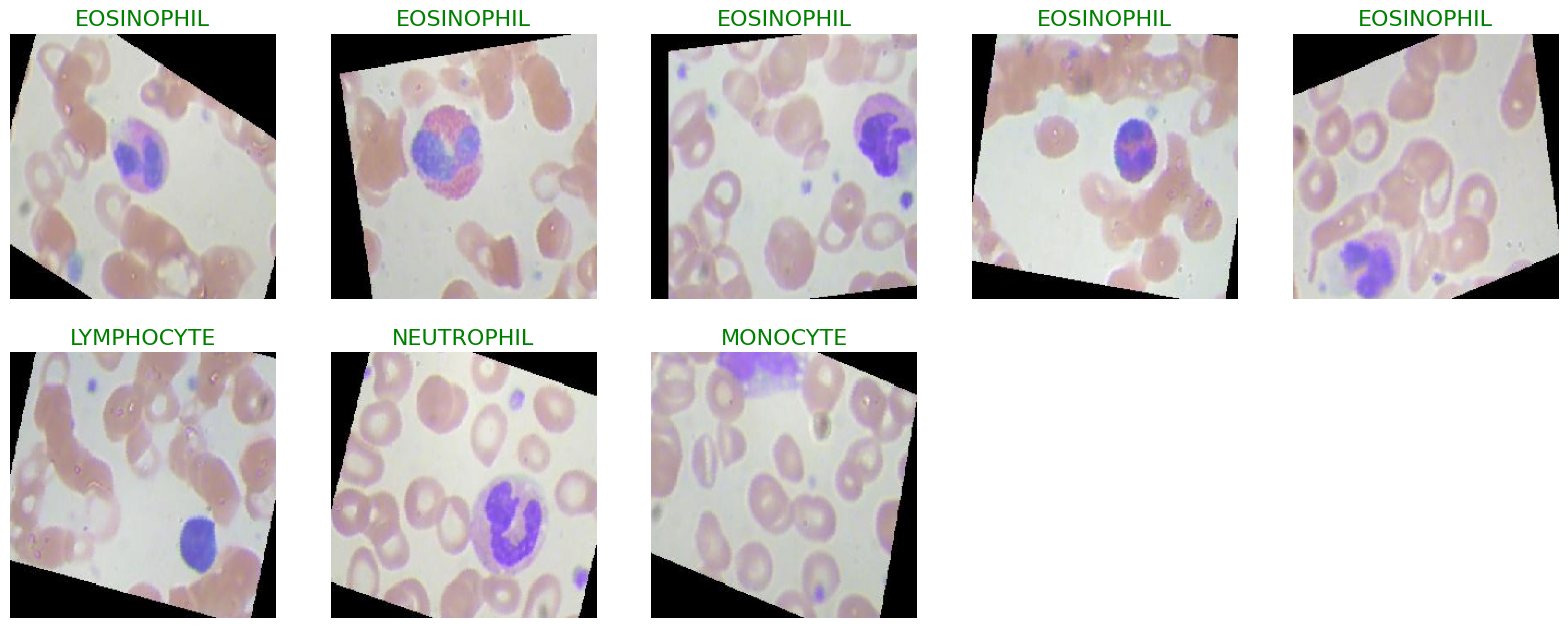

In [152]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [153]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout

inputs = Input(shape=(244, 244, 3))

x = Conv2D(128, (8, 8), strides=(3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)

x = Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3))(x)

x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(256, (1, 1), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(256, (1, 1), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 79, 79, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 79, 79, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 79, 79, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 79, 79, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 26, 26, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 26, 26, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 26, 26, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 26, 26, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 26, 26, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 13, 13, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 13, 13, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 13, 13, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,80

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [154]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [155]:
history = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
996/996 ━━━━━━━━━━━━━━━━━━━━ 634s 635ms/step - accuracy: 0.3171 - loss: 2.0145 - val_accuracy: 0.5678 - val_loss: 1.0168
Epoch 2/5
996/996 ━━━━━━━━━━━━━━━━━━━━ 625s 628ms/step - accuracy: 0.5114 - loss: 1.1233 - val_accuracy: 0.6551 - val_loss: 0.7976
Epoch 3/5
996/996 ━━━━━━━━━━━━━━━━━━━━ 631s 633ms/step - accuracy: 0.6637 - loss: 0.7776 - val_accuracy: 0.7977 - val_loss: 0.4629
Epoch 4/5
996/996 ━━━━━━━━━━━━━━━━━━━━ 636s 638ms/step - accuracy: 0.7895 - loss: 0.5143 - val_accuracy: 0.8599 - val_loss: 0.3272
Epoch 5/5
996/996 ━━━━━━━━━━━━━━━━━━━━ 634s 636ms/step - accuracy: 0.8598 - loss: 0.3509 - val_accuracy: 0.9091 - val_loss: 0.2068


In [156]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

996/996 ━━━━━━━━━━━━━━━━━━━━ 634s 636ms/step - accuracy: 0.9059 - loss: 0.2461 - val_accuracy: 0.9277 - val_loss: 0.1693


In [157]:
model.evaluate(test, verbose=1)

374/374 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.9301 - loss: 0.1582


[0.1477115899324417, 0.9400936961174011]

In [158]:
model.save("Blood Cell.h5")

In [159]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

374/374 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step


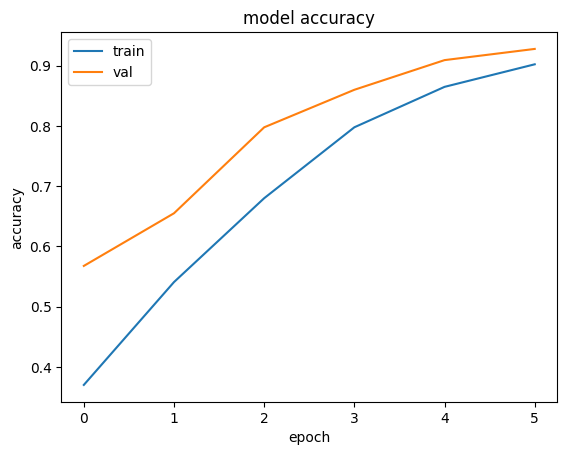

In [160]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

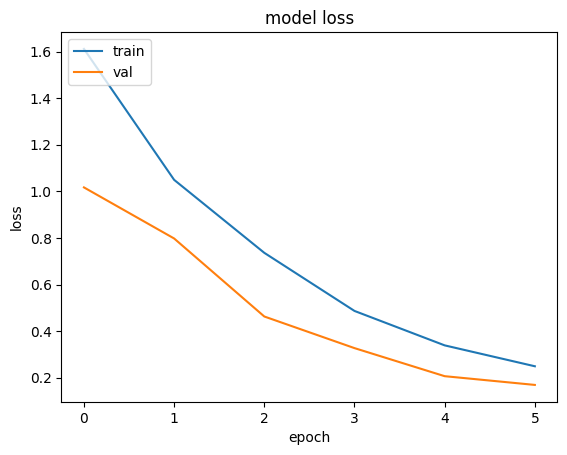

In [161]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [162]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

  EOSINOPHIL       0.88      0.90      0.89       781
  LYMPHOCYTE       0.98      1.00      0.99       764
    MONOCYTE       1.00      1.00      1.00       729
  NEUTROPHIL       0.91      0.86      0.88       714

    accuracy                           0.94      2988
   macro avg       0.94      0.94      0.94      2988
weighted avg       0.94      0.94      0.94      2988

Accuracy of the Model: 94.0%


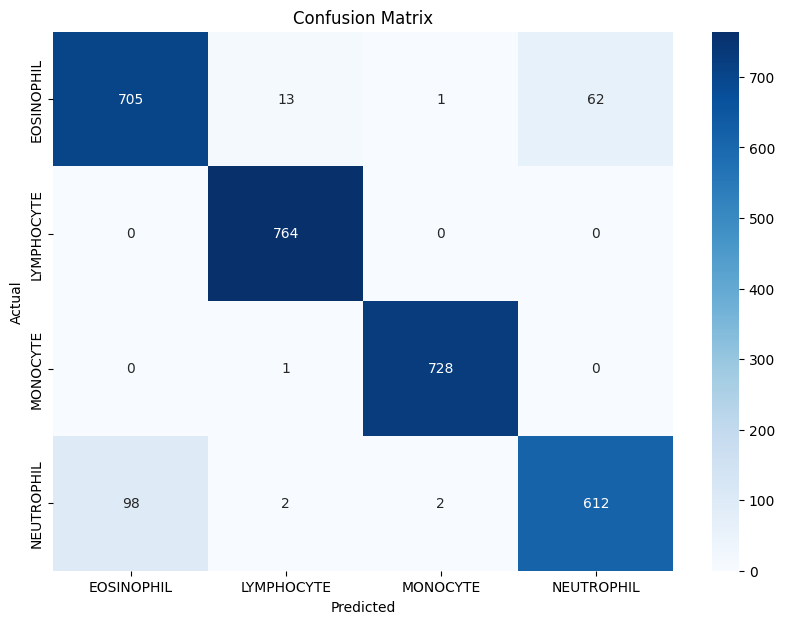

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

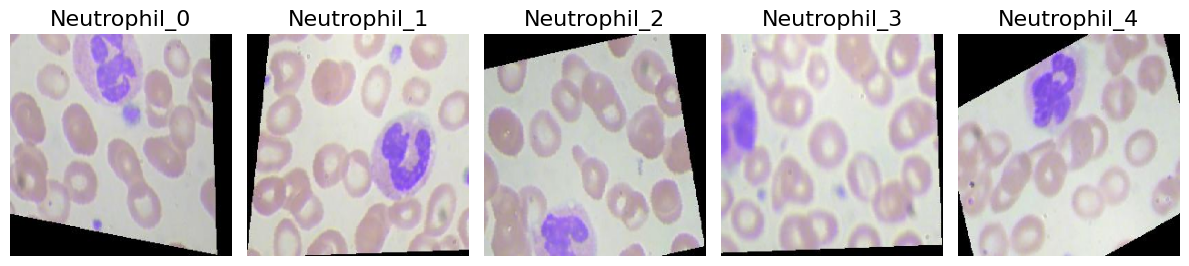

In [182]:
from os import walk

# Image titles

# Load images and Convert them to a Numpy array\
path = os.path.join("dataset2-master", "dataset2-master", "images", "TRAIN", "NEUTROPHIL")
# path = "dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL"
files = []
for dirpath, dirnames, filenames in walk(path):
    for file in filenames:
        full_path = os.path.join(dirpath, file)
        files.append(full_path)

files = files[:100]

images = [keras.preprocessing.image.load_img(file_path, target_size=(244, 244)) for file_path in files]
images = np.asarray([np.array(image) for image in images])

X = keras.applications.vgg16.preprocess_input(images)

# Rendering
image_titles = [f'Neutrophil_{i}' for i in range(5)]
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [181]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()


In [183]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([np.argmax(model.predict(X[i:i+1])) for i in range(len(X))])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

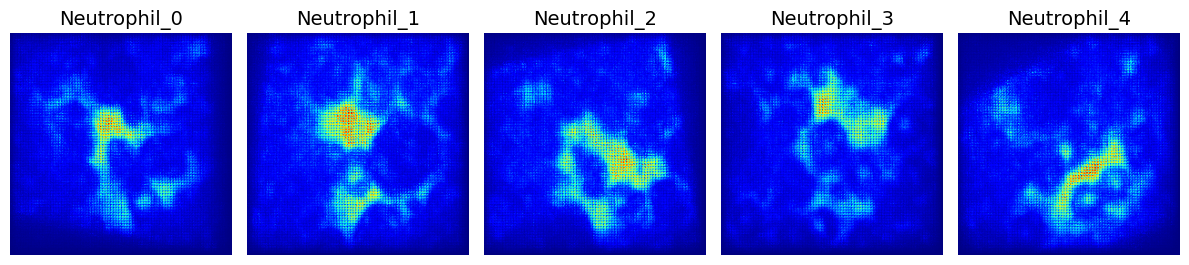

CPU times: total: 30min 17s
Wall time: 3min 2s


In [184]:
%%time
from tf_keras_vis.saliency import Saliency

# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(
    score,
    X,
    smooth_samples=20,  # The number of calculating gradients iterations.
    smooth_noise=0.20)  # noise spread level.

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()